In [1]:
# Denna modul är för att testa olika modeller och parametrar 
# för att hitta den bästa modellen för att förutsäga kryptovalutor
# Dessutom testar jag att ta med inflation och guldpriser som features

# Nu används yfinance för att hämta data från Yahoo Finance
# Testa också att hämta data från Binance

In [1]:
import sklearn
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier
# from pytrends.request import TrendReq
# import pytrends
import sys
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import re

import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
import plotly.express as px
import streamlit as st
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

#Import other useful libraries
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display
# set display witdh to 200
pd.set_option('display.width', 200)
# set display height to 500
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
# pd.options.display.precision = 4      # default 6
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.INFO, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [3]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__)) # type: ignore
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.5
pandas==1.4.4
matplotlib==3.7.0
yfinance==0.2.12
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.1.1
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


In [4]:
# TODO Vilka kryptovalutor ska vi använda?
tickers = ['BTC-USD','ETH-USD','BCH-USD','XRP-USD','ZRX-USD']
horizons=[2,5,15,30,60,90,250]

In [5]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    # Funktionen används inte just nu
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)   
    return df   

def beräkna_cumulative_return(df, ticker_names):
    # Funktionen används inte just nu
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

## Get inflation data US and SE

In [6]:
def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(
        id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['Date'] = pd.to_datetime(inflation['Year'].astype(
        str) + '-' + inflation['month'].astype(str))
    inflation.set_index('Date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(
        inflation, how='left', left_on='Date', right_index=True)
    inflation.set_index('Date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(
        chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


def add_horizon_columns(inflation, horizons, SE=False):
    # print(horizons)
    for horizon in horizons:
        # print(horizon)
        inflation['US_inflation_' + str(horizon)] = \
            inflation['US_inflation'].rolling(horizon, 1).mean()
        if SE:
            inflation['SE_inflation_' +
                  str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()

        # print(inflation.columns)
    return inflation


In [7]:
# US_infl = pd.read_html(
#     'https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
# df_dates = pd.DataFrame(pd.date_range(
#     '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])

# display('Nu SE')
# try:
#     SE_infl = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
# except:
#     display('SE Gick ej bra')
#     SE_infl=pd.DataFrame()
    
# SE_infl

In [8]:
# SE_inflation=SE_infl[0].copy()
# SE_inflation.rename(columns={'År': 'Year'}, inplace=True)
# se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
# SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
# SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
        
# SE_inflation

In [9]:
# US_inflation = US_infl[0].copy()
# US_inflation.replace(to_replace=r'^Avail.*$',
#                      value=np.nan, regex=True, inplace=True)

# US_inflation.columns = US_inflation.iloc[0]
# US_inflation.drop(US_inflation.index[0], inplace=True)
# US_inflation.drop('Ave', axis=1, inplace=True)
# us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    
# US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')
# inflations = pd.concat([US_inflation, SE_inflation], axis=1)
# inflations = inflations.dropna()
# inflations = add_horizon_columns(inflations, [75,90,250])
# inflations

2023-05-02 15:28:26.755 
  command:

    streamlit run c:\Users\peter\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


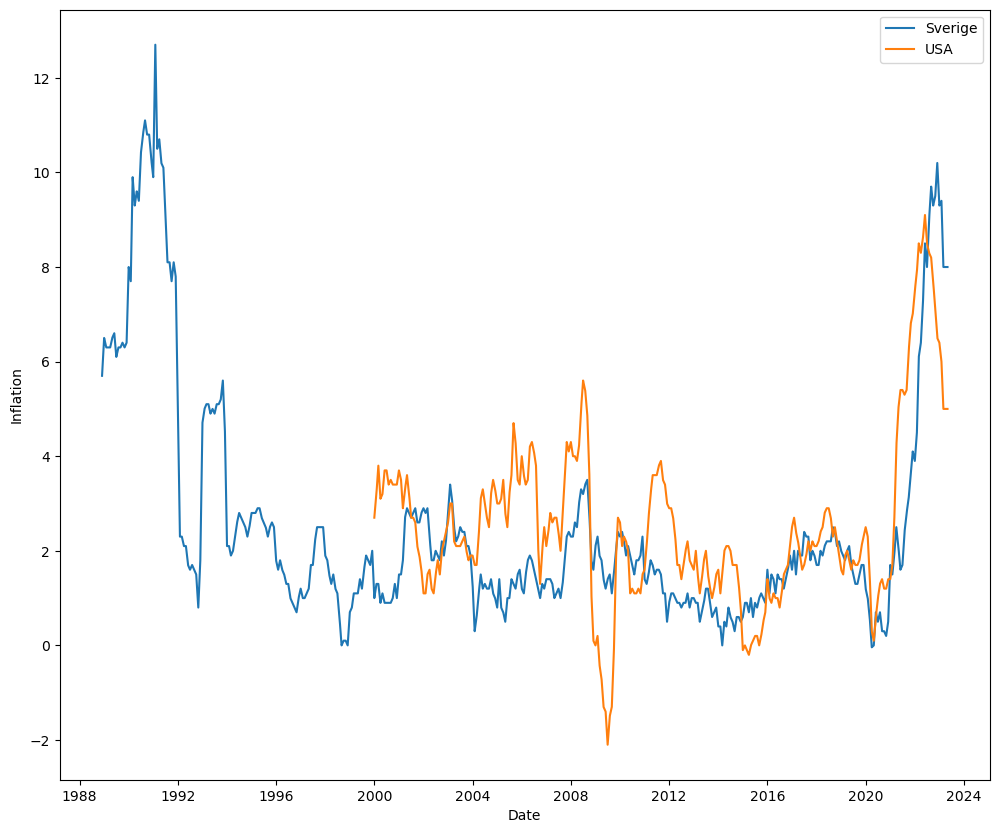

In [10]:

@st.cache_data
def get_inflation_data(graph=False):
    # Explain this function here        
    # Create a dataframe with dates from 1988-12-01 to today
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    # SE_inflation = pd.DataFrame()
    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1).copy()
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [11]:
display(list(inflations.columns))

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [12]:
# fill up a dataframe with all days from 2005 up to today and set it as index
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## Get Gold data from yfinance

(6740, 1)

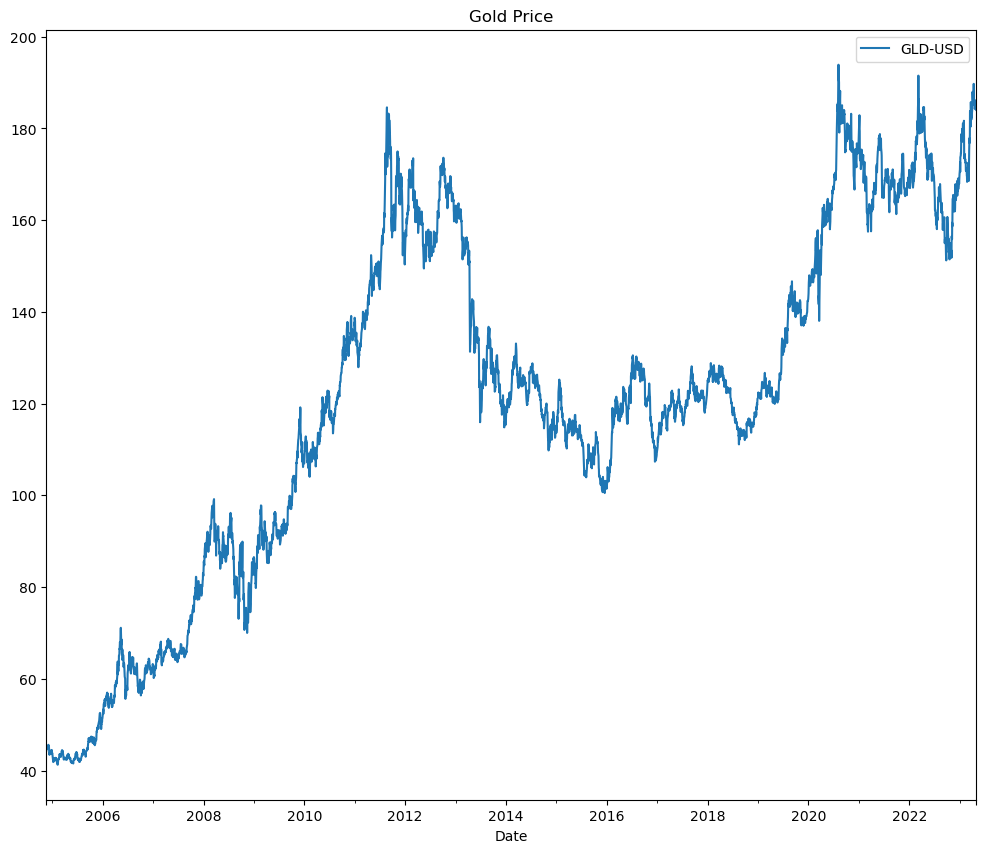

In [13]:
def get_gold_data():
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    df_dates.set_index('Date', inplace=True)
    # Hämta historiska guldprisdata (GLD är ticker-symbolen för SPDR Gold Shares ETF)
    gld_data = yf.download('GLD', end=dt.today().date(), progress=False)
    # gld_data.set_index('Date', inplace=True)
    
    # Behåll endast 'Close' priser och döp om kolumnen till 'GLD-USD'
    gld_data = gld_data[['Close']].rename(columns={'Close': 'GLD-USD'})

    df_dates = pd.DataFrame(pd.date_range(start=gld_data.index[0], end=pd.to_datetime('today').date(), freq='D'), columns=['Date']) # type: ignore

    df_dates.set_index('Date', inplace=True)
    gld_data = df_dates.merge(gld_data, how='left', left_on='Date', right_index=True)
    # interpolating missing values
    gld_data.interpolate(method='linear',inplace=True)
    return gld_data

df_gold = get_gold_data()

display(df_gold.shape)
df_gold.plot(figsize=(12, 10), title='Gold Price')
plt.show()

## Ladda ner all data

In [14]:
def get_all(tickers):
    # Funktionen används inte just nu    
    df = pd.DataFrame()
    for ticker in tickers:
        # all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

# df_org = get_all(tickers)

In [15]:
# FOr backtesting
def fit_predict(train, test, target, predictors, model, proba_val=None):
    
    if train[target].nunique() < 2:
        print('kolumner i train',train.columns)
        print('kolumner i test',test.columns)
        print('target',target)
        print('predictors',predictors)
        print('train\n',train[target].value_counts())
        print('test\n',test[target].value_counts())
        print(
            f"Skipping training for target {target} as it has only one unique value in the training data.")
        # stäng ner programmet
        sys.exit()
        
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined


### Beräkna nya kolumner (predictors)

In [16]:
def create_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    # print(ticker_name)
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
    
    # Target
    # display(df)
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    hpref = 'GLD_' if 'GLD' in ticker else ''
    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"{hpref}Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"{hpref}Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]  

        predictors += [ratio_column, trend_column]

    return df, predictors


In [18]:
### get the data ###
df_grid = get_all(tickers)
display('grid:',df_grid.shape)
# inflations = get_inflation_data(graph=False)
display('inflations:',inflations.shape)
df_gold = get_gold_data()
display('gold:',df_gold.shape)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


'grid:'

(3150, 5)

'inflations:'

(8523, 8)

'gold:'

(6740, 1)

### Vi gör viss preprocessing för en valuta i taget - nya kolumner

In [19]:
### preprocessing ###

df = pd.DataFrame()
target = 'y1'  # tomorrow
for ticker in tickers:
    # print(ticker)
    df_temp, pred = create_predictors(
        df_grid[[ticker]], ticker, target, horizons=horizons)
    df_temp = df_temp.reset_index()
    df_temp['Ticker'] = ticker
    df = pd.concat([df, df_temp], axis=0)

print('Dessa skall vara lika',sum(df.Date.value_counts()==5)*5,'=',len(df) )
df.Date.value_counts()

Dessa skall vara lika 15750 = 15750


2014-09-17    5
2020-06-09    5
2020-06-11    5
2020-06-12    5
2020-06-13    5
             ..
2017-08-04    5
2017-08-05    5
2017-08-06    5
2017-08-07    5
2023-05-02    5
Name: Date, Length: 3150, dtype: int64

### create new predictors GOld

In [20]:
target = 'y1'  # tomorrow
ticker = ['GLD-USD'][0]
# display(df_gold[[ticker]])
dfg, pred = create_predictors(
    df_gold[[ticker]], ticker, target, horizons=horizons)
dfg = dfg.reset_index()

print('Dessa skall vara lika', sum(dfg.Date.value_counts() == 1)*1, '=', len(dfg))
display(dfg.Date.value_counts())
dfg.set_index('Date', inplace=True)
df_gold = dfg[pred].copy()
df_gold

Dessa skall vara lika 6740 = 6740


2004-11-18    1
2017-02-20    1
2017-03-16    1
2017-03-15    1
2017-03-14    1
             ..
2011-01-08    1
2011-01-07    1
2011-01-06    1
2011-01-05    1
2023-05-02    1
Name: Date, Length: 6740, dtype: int64

,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250
Date,,,,,,,,,,,,,,
2004-11-18,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN
2004-11-19,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999
2004-11-20,1.000632,44.808332,1.003831,44.808332,1.003831,44.808332,1.003831,44.808332,1.003831,44.808332,1.003831,44.808332,1.003831,44.808332
2004-11-21,1.000632,44.865000,1.003820,44.836666,1.003820,44.836666,1.003820,44.836666,1.003820,44.836666,1.003820,44.836666,1.003820,44.836666
2004-11-22,1.000631,44.921667,1.004065,44.865000,1.004065,44.865000,1.004065,44.865000,1.004065,44.865000,1.004065,44.865000,1.004065,44.865000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,1.000135,184.775002,0.999081,184.970001,0.997251,185.309333,0.995808,185.578000,1.017889,181.552166,1.034306,178.670481,1.095888,168.630419
2023-04-29,0.999251,184.661669,0.997895,184.912669,0.996417,185.186889,0.994256,185.589445,1.014992,181.797889,1.032398,178.732815,1.093653,168.721953
2023-04-30,0.999250,184.385002,0.998021,184.612003,0.995581,185.064445,0.992582,185.623667,1.012218,182.022666,1.030498,178.793778,1.091458,168.807859


In [21]:
print('df innan merge')
df=df.set_index('Date')
print(df.shape)
df=df.merge(inflations, left_index=True,
          right_index=True, how='left')

df = df.merge(df_gold, left_index=True, 
           right_index=True, how='left')
print('df efter merge')
print(df.shape)
# df_inflations.shape'
df.sample(20)

df innan merge
(15750, 24)
df efter merge
(15750, 46)


,BTC-USD,Tomorrow,After_tomorrow,y1,y2,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_15,Trend_15,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,Ticker,ETH-USD,BCH-USD,XRP-USD,ZRX-USD,US_inflation,SE_inflation,US_inflation_75,SE_inflation_75,US_inflation_90,SE_inflation_90,US_inflation_250,SE_inflation_250,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-28,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ETH-USD,NaN,NaN,NaN,NaN,2.225806,1.935484,2.485140,1.771935,2.491487,1.753387,1.971316,1.597587,0.997946,119.285000,0.998959,119.164000,1.009978,117.864000,1.015804,117.188000,1.016066,117.157750,1.027624,115.840056,0.998747,119.189400
2017-07-06,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ETH-USD,NaN,NaN,NaN,NaN,1.732258,2.383871,1.729424,2.037622,1.784520,2.023573,2.122148,1.859329,0.999785,116.494999,1.000398,116.423664,0.988125,117.869665,0.979891,118.860166,0.978057,119.083083,0.974163,119.559055,0.996660,116.860340
2017-08-29,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XRP-USD,NaN,NaN,NaN,NaN,2.170968,2.300000,1.864387,2.314667,1.824211,2.265000,2.102394,1.979942,0.998916,124.555000,1.004554,123.856000,1.013242,122.794001,1.021114,121.847334,1.039100,119.738250,1.038650,119.790055,1.053956,118.050500
2015-10-29,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ETH-USD,NaN,NaN,NaN,NaN,0.470968,1.009677,0.180086,1.028839,0.175878,0.998226,0.078716,0.880561,0.995193,110.250000,0.988356,111.012667,0.981688,111.766667,0.990151,110.811333,1.003283,109.360916,1.009984,108.635388,0.984034,111.500180
2018-05-10,NaN,1371.739990,1472.400024,0,0,0.965345,1583.464966,0.932094,1639.951953,1.008481,1515.734652,1.226004,1246.806828,1.465005,1043.402213,1.366166,1118.890367,1.025992,1489.864864,BCH-USD,NaN,1528.589966,NaN,NaN,2.829032,2.129032,2.572316,1.992507,2.529311,1.972327,2.270607,1.905247,1.003407,124.755001,1.004284,124.646000,1.004596,124.607333,0.995246,125.778000,0.993402,126.011417,0.993334,126.020056,1.007699,124.223640
2016-11-27,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BCH-USD,NaN,NaN,NaN,NaN,2.046667,1.860000,1.711600,1.545200,1.678792,1.493659,1.267159,1.399421,1.001752,113.205002,1.003214,113.040001,0.986225,114.987334,0.958111,118.361334,0.946692,119.789000,0.929133,122.052889,0.924730,122.633940
2015-12-30,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ETH-USD,NaN,NaN,NaN,NaN,1.354839,1.554839,0.734151,1.076796,0.658029,1.076362,0.310130,0.947050,0.996169,101.809998,0.992339,102.202998,0.990772,102.364666,0.990130,102.431000,0.983870,103.082694,0.959400,105.711944,0.932367,108.776940
2018-08-15,NaN,0.718532,0.830135,1,1,1.004140,0.681838,0.889515,0.769701,0.776681,0.881521,0.671354,1.019822,0.730371,0.937416,0.668175,1.024673,0.663893,1.031282,ZRX-USD,NaN,NaN,NaN,0.684661,2.519355,2.335484,2.801935,2.213548,2.814516,2.207527,2.543181,2.001787,0.991617,112.130001,0.984209,112.974001,0.974234,114.130667,0.966052,115.097333,0.949982,117.044278,0.934695,118.958556,0.904258,122.962660
2018-03-20,NaN,561.731995,539.702026,1,0,1.000403,556.950500,0.992478,561.397998,0.849631,655.784403,0.733197,759.925035,0.646878,861.329034,0.619234,899.780712,0.728158,765.183963,ETH-USD,557.174988,NaN,NaN,NaN,2.461290,1.938710,2.281247,1.825828,2.251254,1.809588,2.135039,1.967955,0.997753,124.590000,0.997272,124.650000,0.992120,125.297333,0.990386,125.516666,0.985340,126.159500,0.989708,125.602667,1.009047,123.195500


In [22]:
df.dropna(subset=['Tomorrow'], inplace=True)
df.dropna(subset=[target], inplace=True)
df2 = df.drop(columns=['After_tomorrow', 'ETH-USD','BTC-USD',	'BCH-USD',	'XRP-USD',	'ZRX-USD'])
df2.shape


(11153, 40)

In [23]:

df2.sort_index(ascending=True, inplace=True)
df2.dropna(inplace=True)

### Include variance (diff)

In [24]:
def add_diff(df_, new_col, col_list):
    df = df_.copy()
    df[new_col] = df.apply(lambda row: max(
        [row[col] for col in col_list]) - min([row[col] for col in col_list]), axis=1)
    return df


ticker_trends = [col for col in df2.columns if 'Trend' in col and 'GLD' not in col]
print(ticker_trends)
df2 = add_diff(df2, 'ticker_diff', ticker_trends)
infl_trends = [col for col in df2.columns if 'US_inflation' in col]
print(infl_trends)
df2 =add_diff(df2, 'infl_diff', infl_trends)
gold_trends = [col for col in df2.columns if 'GLD_Trend' in col]
print(gold_trends)
df2 =add_diff(df2, 'gold_diff', gold_trends)
df2

['Trend_2', 'Trend_5', 'Trend_15', 'Trend_30', 'Trend_60', 'Trend_90', 'Trend_250']
['US_inflation', 'US_inflation_75', 'US_inflation_90', 'US_inflation_250']
['GLD_Trend_2', 'GLD_Trend_5', 'GLD_Trend_15', 'GLD_Trend_30', 'GLD_Trend_60', 'GLD_Trend_90', 'GLD_Trend_250']


,Tomorrow,y1,y2,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_15,Trend_15,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,Ticker,US_inflation,SE_inflation,US_inflation_75,SE_inflation_75,US_inflation_90,SE_inflation_90,US_inflation_250,SE_inflation_250,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250,ticker_diff,infl_diff,gold_diff
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-18,394.795990,0,0,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,BTC-USD,1.7,0.47,1.745290,0.447497,1.788704,0.476630,1.777948,0.443520,1.001020,117.660000,0.995868,118.268667,0.983768,119.723334,0.970340,121.380167,0.954917,123.340583,0.945668,124.546944,0.945180,124.611186,0.000000,0.088704,6.951187
2014-09-19,408.903992,1,1,0.963815,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,BTC-USD,1.7,0.48,1.741935,0.446112,1.785000,0.474556,1.779058,0.443840,0.997062,117.434998,0.992490,117.975999,0.980401,119.430667,0.966548,121.142500,0.950511,123.186417,0.940927,124.441092,0.939754,124.596480,0.000000,0.085000,7.161482
2014-09-20,398.821014,0,0,1.017554,401.849991,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,BTC-USD,1.7,0.49,1.738710,0.444903,1.781333,0.472667,1.780232,0.444200,0.999658,117.049997,0.994560,117.649999,0.982501,119.094000,0.967450,120.946834,0.950984,123.040917,0.941101,124.333055,0.939232,124.580440,7.530004,0.081333,7.530443
2014-09-21,402.152008,1,1,0.987517,403.862503,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,BTC-USD,1.7,0.50,1.735613,0.443871,1.777704,0.470963,1.781471,0.444600,0.999658,116.969997,0.997101,117.269998,0.984412,118.781555,0.968459,120.738167,0.951454,122.896083,0.941292,124.222833,0.938680,124.568600,2.877747,0.081471,7.598602
2014-09-22,435.790985,1,1,1.004159,400.486511,0.990955,405.822601,0.970426,405.822601,0.970426,405.822601,0.970426,405.822601,0.970426,405.822601,0.970426,405.822601,BTC-USD,1.7,0.51,1.732645,0.443015,1.774111,0.469444,1.782774,0.445040,0.999658,116.889998,0.997592,117.131998,0.986131,118.493333,0.969453,120.531833,0.951771,122.771083,0.941501,124.110277,0.938122,124.557360,5.336090,0.082774,7.667362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,28084.078125,0,0,0.979476,28680.187500,0.965858,29084.582422,0.981592,28618.374089,0.973815,28846.925651,1.037022,27088.678581,1.087430,25832.998112,1.312401,21404.712359,BTC-USD,5.0,8.00,5.043333,8.060667,5.161111,8.225556,6.348561,9.086871,0.999249,184.108335,0.997354,184.458002,0.994744,184.942000,0.991036,185.634000,1.009468,182.244500,1.028659,178.844444,1.089284,168.890739,7679.870062,1.348561,16.743261
2023-05-01,1832.075684,1,0,0.987875,1854.439575,0.972469,1883.819067,0.959415,1909.449504,0.955368,1917.537793,1.018079,1799.422245,1.051739,1741.833838,1.214153,1508.833583,ETH-USD,5.0,8.00,5.043333,8.060667,5.161111,8.225556,6.348561,9.086871,0.999249,184.108335,0.997354,184.458002,0.994744,184.942000,0.991036,185.634000,1.009468,182.244500,1.028659,178.844444,1.089284,168.890739,408.704210,1.348561,16.743261
2023-05-01,118.383064,1,0,0.994731,117.596928,0.990891,118.052634,0.962629,121.518592,0.937029,124.838417,0.938278,124.672329,0.916553,127.627351,0.987833,118.418089,BCH-USD,5.0,8.00,5.043333,8.060667,5.161111,8.225556,6.348561,9.086871,0.999249,184.108335,0.997354,184.458002,0.994744,184.942000,0.991036,185.634000,1.009468,182.244500,1.028659,178.844444,1.089284,168.890739,10.030424,1.348561,16.743261


In [25]:
df2.columns



Index(['Tomorrow', 'y1', 'y2', 'Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90', 'Ratio_250', 'Trend_250',
       'Ticker', 'US_inflation', 'SE_inflation', 'US_inflation_75', 'SE_inflation_75', 'US_inflation_90', 'SE_inflation_90', 'US_inflation_250', 'SE_inflation_250', 'GLD_Ratio_2', 'GLD_Trend_2',
       'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15', 'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250',
       'ticker_diff', 'infl_diff', 'gold_diff'],
      dtype='object')

In [26]:
predictors = ['Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90',
              'Ratio_250', 'Trend_250', 'GLD_Ratio_2', 'GLD_Trend_2', 'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15',
              'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250', 
              'US_inflation', 'US_inflation_75', 'US_inflation_90', 'US_inflation_250','ticker_diff', 'infl_diff', 'gold_diff']


In [27]:
df2[predictors].head(40)

,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_15,Trend_15,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250,US_inflation,US_inflation_75,US_inflation_90,US_inflation_250,ticker_diff,infl_diff,gold_diff
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-18,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,1.001020,117.660000,0.995868,118.268667,0.983768,119.723334,0.970340,121.380167,0.954917,123.340583,0.945668,124.546944,0.945180,124.611186,1.700000,1.745290,1.788704,1.777948,0.000000,0.088704,6.951187
2014-09-19,0.963815,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.997062,117.434998,0.992490,117.975999,0.980401,119.430667,0.966548,121.142500,0.950511,123.186417,0.940927,124.441092,0.939754,124.596480,1.700000,1.741935,1.785000,1.779058,0.000000,0.085000,7.161482
2014-09-20,1.017554,401.849991,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.999658,117.049997,0.994560,117.649999,0.982501,119.094000,0.967450,120.946834,0.950984,123.040917,0.941101,124.333055,0.939232,124.580440,1.700000,1.738710,1.781333,1.780232,7.530004,0.081333,7.530443
2014-09-21,0.987517,403.862503,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.999658,116.969997,0.997101,117.269998,0.984412,118.781555,0.968459,120.738167,0.951454,122.896083,0.941292,124.222833,0.938680,124.568600,1.700000,1.735613,1.777704,1.781471,2.877747,0.081471,7.598602
2014-09-22,1.004159,400.486511,0.990955,405.822601,0.970426,405.822601,0.970426,405.822601,0.970426,405.822601,0.970426,405.822601,0.970426,405.822601,0.999658,116.889998,0.997592,117.131998,0.986131,118.493333,0.969453,120.531833,0.951771,122.771083,0.941501,124.110277,0.938122,124.557360,1.700000,1.732645,1.774111,1.782774,5.336090,0.082774,7.667362
2014-09-23,1.040145,418.971497,1.067872,408.092798,1.043904,410.817332,1.043904,410.817332,1.043904,410.817332,1.043904,410.817332,1.043904,410.817332,1.003199,117.224998,1.004304,117.095998,0.994212,118.284666,0.977105,120.355500,0.958946,122.634583,0.948342,124.005944,0.944210,124.548600,1.700000,1.729806,1.770556,1.784142,10.878699,0.084142,7.452602
2014-09-24,0.985348,429.497986,1.022791,413.774597,1.012015,412.586997,1.012015,412.586997,1.012015,412.586997,1.012015,412.586997,1.012015,412.586997,0.997656,117.325001,0.999675,117.087999,0.991697,118.029999,0.974071,120.165833,0.955588,122.490083,0.944726,123.898388,0.939911,124.533080,1.700000,1.727097,1.767037,1.785574,16.910989,0.085574,7.445081
2014-09-25,0.986067,417.389496,0.993400,414.308600,0.985933,412.460373,0.985933,412.460373,0.985933,412.460373,0.985933,412.460373,0.985933,412.460373,1.001450,117.220001,1.001929,117.163999,0.996193,117.838666,0.978518,119.967167,0.959442,122.352417,0.948258,123.795388,0.942739,124.520150,1.700000,1.724516,1.763556,1.787071,4.929123,0.087071,7.356150
2014-09-26,0.991239,407.999496,0.973511,415.429395,0.971839,411.567552,0.971839,411.567552,0.971839,411.567552,0.971839,411.567552,0.971839,411.567552,0.998592,117.224998,0.998891,117.189999,0.994748,117.677999,0.977467,119.758500,0.957856,122.210416,0.946447,123.683611,0.940187,124.507130,1.700000,1.722065,1.760111,1.788632,7.429898,0.088632,7.317130


### Preprocessing för alla valutor tillsammans

In [28]:

tscv = TimeSeriesSplit(n_splits=5)

In [29]:
l = predictors+['y1']
print(l)
X = df2[l].dropna()
y = X['y1']
X = X.drop(['y1'], axis=1)
print(y.shape)
X.shape

['Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90', 'Ratio_250', 'Trend_250', 'GLD_Ratio_2', 'GLD_Trend_2', 'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15', 'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250', 'US_inflation', 'US_inflation_75', 'US_inflation_90', 'US_inflation_250', 'ticker_diff', 'infl_diff', 'gold_diff', 'y1']
(11148,)


(11148, 35)

#### Välj mellan GridSearch och RandomSearch

In [38]:
randomsearch = True   # RandmSearchCV för de två tunga modellerna


def combinations(param_list):
    total_combinations = 1
    for key in param_list:
        if key.startswith('classifier__'):
            total_combinations *= len(param_list[key])
    return total_combinations


In [48]:
# Initialize the hyperparameters for each dictionary
# each having a key as ‘classifier’ and value as estimator object.
#The hyperparameter keys should start with the word classifier separated
# by ‘__’ (double underscore)

# Define parameters for CatBoostClassifier
paramCat = {}
paramCat['classifier__iterations'] = [100, 250, 300, 350]
paramCat['classifier__depth'] = [3, 5, 7]
# paramCat['classifier__class_weights'] = [{0: 1, 1: 1}, {0: 1, 1: 2} ]
paramCat['classifier__learning_rate'] = [0.01, 0.03, 0.05, 0.07]
paramCat['classifier'] = [CatBoostClassifier(random_state=42, verbose=False)]
print('Total combinations for CatBoostClassifier = ', combinations(paramCat))

# Define parameters for XGBClassifier
paramXGB = {}
paramXGB['classifier__n_estimators'] = [50, 100, 250, 350]
paramXGB['classifier__max_depth'] = [2, 3, 5, 10]
paramXGB['classifier__learning_rate'] = [0.01, 0.03, 0.05, 0.07]
# paramXGB['classifier__scale_pos_weight'] = [1, 5, 10]
paramXGB['classifier'] = [XGBClassifier(
    random_state=42, eval_metric='logloss')]
print('Total combinations for XGBClassifier = ', combinations(paramXGB))


# Define parameters for Random Forest
paramRF = {}
paramRF['classifier__n_estimators'] = [75, 100, 200, 350, 400]
paramRF['classifier__max_depth'] = [ 4, 5, 10, 12]
paramRF['classifier__min_samples_split'] = [2, 5, 10]
paramRF['classifier__min_samples_leaf'] = [1,2,4]
paramRF['classifier__max_features'] = ['auto', 'sqrt']
paramRF['classifier__bootstrap'] = [True, False]
paramRF['classifier'] = [RandomForestClassifier(random_state=42)]
print('Total combinations for RandomForestClassifier = ', combinations(paramRF))

# Define parameters for support vector machine (SVC)
paramSVC = {}
paramSVC['classifier__kernel'] = ['linear', 'rbf']
paramSVC['classifier__C'] = [0.001, 0.01, 1, 10, 100]
paramSVC['classifier__gamma'] = ['scale', 'auto', 0.1, 1, 10]
paramSVC['classifier__shrinking'] = [True, False]
paramSVC['classifier'] = [SVC(random_state=42)]
print('Total combinations for SVC = ', combinations(paramSVC))

# Define parameters for Logistic regression
paramLR = {}
paramLR['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1]
paramLR['classifier__penalty'] = ['l1', 'l2']
paramLR['classifier__solver'] = ['liblinear', 'saga']  # or 'saga'
paramLR['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}]
paramLR['classifier'] = [LogisticRegression(random_state=42)]
print('Total combinations for LogisticRegression = ', combinations(paramLR))

# Define parameters for K neighbors classifier
paramKN = {}
paramKN['classifier__n_neighbors'] = [2, 5, 7, 10, 20]
paramKN['classifier__weights'] = ['uniform', 'distance']
paramKN['classifier__algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']
paramKN['classifier__leaf_size'] = [10, 30, 50]
paramKN['classifier'] = [KNeighborsClassifier()]
print('Total combinations for KNeighborsClassifier = ', combinations(paramKN))

# Define parameters for Gradient boosting
paramGBC = {}
paramGBC['classifier__n_estimators'] = [10, 50, 100, 200, 300]
paramGBC['classifier__max_depth'] = [3, 5, 10, 20]
paramGBC['classifier__min_samples_split'] = [2, 5, 10]
paramGBC['classifier__min_samples_leaf'] = [1, 2, 4]
# paramGBC['classifier__max_features'] = ['auto', 'sqrt', 'log2', None]
# paramGBC['classifier__subsample'] = [0.5, 0.8, 1.0]
# paramGBC['classifier__loss'] = ['deviance', 'exponential']

paramGBC['classifier'] = [GradientBoostingClassifier(random_state=42)]
print('Total combinations for GradientBoostingClassifier = ', combinations(paramGBC))

# define the pipeline to include scaling and the model.
# Prepare the pipeline for the 1st model, others will be loaded appropriately
#during the Grid Search
#This pipeline will be the input to cross_val_score, instead of the model.
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('classifier', RandomForestClassifier(random_state=42)))
pipeline = Pipeline(steps=steps)

#Capture all parameter dictionaries as a list
params = [paramSVC, paramLR, paramKN, paramGBC]
# Total parameters for all 5 models = 27+20+48+5+9 = 109

Total combinations for CatBoostClassifier =  48
Total combinations for XGBClassifier =  64
Total combinations for RandomForestClassifier =  720
Total combinations for SVC =  100
Total combinations for LogisticRegression =  48
Total combinations for KNeighborsClassifier =  120
Total combinations for GradientBoostingClassifier =  180


### GridSearchCV för lätta modeller

In [32]:
# take the time
start_time = time.time()
#Grid search - including cross validation
grid = GridSearchCV(pipeline, params, cv=tscv, n_jobs=-
                    1, scoring='roc_auc').fit(X, y)

#Gridsearch object (in our case 'grid') stores all the information about
#the best model and corresponding hyperparameters.
# print the best parameters...
print(grid.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid.best_score_)

# Stats for each test - we have a total 125 tests
means = grid.cv_results_['mean_test_score']
params_summary = grid.cv_results_['params']
# print the time taken
print("--- %s seconds ---" % round((time.time() - start_time),1))

{'classifier': GradientBoostingClassifier(max_depth=5, min_samples_leaf=4, n_estimators=300,
                           random_state=42), 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
0.535746750894055
--- 4373.1 seconds ---


In [40]:

#Capture all data into a Data Frame
df_res1 = pd.DataFrame(list(zip(means, params_summary)),
                  columns=['Mean Score', 'Parmeters']).sort_values(by=['Mean Score'], ascending=False)


In [41]:
df_res1 = df_res1.sort_values(by='Mean Score', ascending=False)
df_res1.to_csv('GridSearchResults1.csv', index=False)

In [42]:
df_res1 = pd.read_csv('GridSearchResults1.csv')

df_res1.head()

,Mean Score,Parmeters
0,0.535747,"{'classifier': GradientBoostingClassifier(max_depth=5, m..."
1,0.535747,"{'classifier': GradientBoostingClassifier(max_depth=5, m..."
2,0.532781,"{'classifier': GradientBoostingClassifier(max_depth=5, m..."
3,0.532781,"{'classifier': GradientBoostingClassifier(max_depth=5, m..."
4,0.531641,"{'classifier': GradientBoostingClassifier(max_depth=5, m..."


### RandomizedSearchCV av de två tunga modellerna

In [49]:
if randomsearch:
    from sklearn.model_selection import RandomizedSearchCV

    # Add the new parameter dictionaries to the list
    params = [paramCat, paramXGB, paramRF]

    # Number of iterations for randomized search
    n_iter_search = 30

    #### Random search RF - including cross validation ####
    # Take the time
    start_time = time.time()
    random2a = RandomizedSearchCV(
        pipeline, param_distributions=params[2], n_iter=n_iter_search, cv=tscv, n_jobs=-1, scoring='roc_auc', random_state=42).fit(X, y)

    # print the best parameters...
    print(random2a.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(random2a.best_score_)

    # Stats for each test - we have a total 48 tests
    means2a = random2a.cv_results_['mean_test_score']
    params_summary2a = random2a.cv_results_['params']

    #Capture all data into a Data Frame
    df_res2a = pd.DataFrame(list(zip(means2a, params_summary2a)),
                            columns=['Mean Score', 'Parmeters'])

    # Take the time
    print("--- The RF time was %s seconds ---" %round((time.time() - start_time), 1))
    df_res2a = df_res2a.sort_values(by='Mean Score', ascending=False)
    df_res2a.to_csv('RandomSearchResults2a.csv', index=False)

    display(df_res2a.head())
    
    
    #### Random search XGB - including cross validation ####
    # Take the time
    start_time = time.time()
    random2b = RandomizedSearchCV(
        pipeline, param_distributions=params[1], n_iter=n_iter_search, cv=tscv, n_jobs=-1, scoring='roc_auc', random_state=42).fit(X, y)

    # print the best parameters...
    print(random2b.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(random2b.best_score_)

    # Stats for each test - we have a total 48 tests
    means2b = random2b.cv_results_['mean_test_score']
    params_summary2b = random2b.cv_results_['params']

    #Capture all data into a Data Frame
    df_res2b = pd.DataFrame(list(zip(means2b, params_summary2b)),
                            columns=['Mean Score', 'Parmeters'])

    # Take the time
    print("--- The XGB time was %s seconds ---" % round((time.time() - start_time), 1))
    df_res2b = df_res2b.sort_values(by='Mean Score', ascending=False)
    df_res2b.to_csv('RandomSearchResults2b.csv', index=False)

    display(df_res2b.head())

    #### Random search CATB - including cross validation ####
    # Take the time
    start_time = time.time()
    random2c = RandomizedSearchCV(
        pipeline, param_distributions=params[0], n_iter=n_iter_search, cv=tscv, n_jobs=-1, scoring='roc_auc', random_state=42).fit(X, y)

    # print the best parameters...
    print(random2c.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(random2c.best_score_)

    # Stats for each test - we have a total 144 tests
    means2c = random2c.cv_results_['mean_test_score']
    params_summary2c = random2c.cv_results_['params']

    #Capture all data into a Data Frame
    df_res2c = pd.DataFrame(list(zip(means2c, params_summary2c)),
                            columns=['Mean Score', 'Parmeters'])
    df_res2c =df_res2c.sort_values(by='Mean Score', ascending=False)  
    df_res2c.to_csv('RandomSearchResults2c.csv', index=False)

    display(df_res2c.head())
    # Take the time
    print("--- The Cat time was %s seconds ---" % round((time.time() - start_time), 1))


{'classifier__n_estimators': 75, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'auto', 'classifier__max_depth': 12, 'classifier__bootstrap': True, 'classifier': RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=75, random_state=42)}
0.5275476450659387
--- The RF time was 73.2 seconds ---


,Mean Score,Parmeters
1,0.527548,"{'classifier__n_estimators': 75, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'auto', 'classifier__max_depth': 12, 'classifier__bootstrap': True, 'classifier': RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=75, random_state=42)}"
15,0.527037,"{'classifier__n_estimators': 350, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 12, 'classifier__bootstrap': True, 'classifier': RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=75, random_state=42)}"
27,0.525938,"{'classifier__n_estimators': 75, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'auto', 'classifier__max_depth': 10, 'classifier__bootstrap': True, 'classifier': RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=75, random_state=42)}"
26,0.525560,"{'classifier__n_estimators': 400, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10, 'classifier__bootstrap': True, 'classifier': RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=75, random_state=42)}"
18,0.525475,"{'classifier__n_estimators': 400, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10, 'classifier__bootstrap': True, 'classifier': RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5, n_estimators=75, random_state=42)}"


{'classifier__n_estimators': 250, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.07, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)}
0.5283774754050299
--- The XGB time was 93.4 seconds ---


,Mean Score,Parmeters
25,0.528377,"{'classifier__n_estimators': 250, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.07, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.07, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=3, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=250, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=42, ...)}"
27,0.528273,"{'classifier__n_estimators': 350, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.07, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.07, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=3, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=250, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=42, ...)}"
1,0.526475,"{'classifier__n_estimators': 250, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.07, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.07, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=3, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=250, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=42, ...)}"
23,0.523363,"{'classifier__n_estimators': 350, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.05, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.07, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=3, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=250, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=42, ...)}"
29,0.522025,"{'classifier__n_estimators': 250, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.03, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.07, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=3, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=250, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=42, ...)}"


{'classifier__learning_rate': 0.03, 'classifier__iterations': 250, 'classifier__depth': 7, 'classifier': <catboost.core.CatBoostClassifier object at 0x00000244A4A2F370>}
0.5311846184932081


,Mean Score,Parmeters
5,0.531185,"{'classifier__learning_rate': 0.03, 'classifier__iterations': 250, 'classifier__depth': 7, 'classifier': <catboost.core.CatBoostClassifier object at 0x00000244A4A2F370>}"
22,0.530863,"{'classifier__learning_rate': 0.01, 'classifier__iterations': 100, 'classifier__depth': 7, 'classifier': <catboost.core.CatBoostClassifier object at 0x00000244A4A2F370>}"
17,0.530180,"{'classifier__learning_rate': 0.03, 'classifier__iterations': 350, 'classifier__depth': 7, 'classifier': <catboost.core.CatBoostClassifier object at 0x00000244A4A2F370>}"
14,0.530068,"{'classifier__learning_rate': 0.03, 'classifier__iterations': 100, 'classifier__depth': 7, 'classifier': <catboost.core.CatBoostClassifier object at 0x00000244A4A2F370>}"
26,0.529931,"{'classifier__learning_rate': 0.05, 'classifier__iterations': 350, 'classifier__depth': 5, 'classifier': <catboost.core.CatBoostClassifier object at 0x00000244A4A2F370>}"


--- The Cat time was 107.7 seconds ---


### GridSearchCV

In [50]:
if not randomsearch:
    # Make GridSearch one by one for each model - because it takes so long time
    params = [paramCat, paramXGB, paramRF]

    #### search XGB ####
    start_time = time.time()
    grid2a = GridSearchCV(pipeline, params, cv=tscv, n_jobs=-
                        1, scoring='roc_auc').fit(X, y)

    # print the best parameters...
    print(grid2a.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(grid2a.best_score_)

    # Stats for each test - we have a total 48 tests
    means2a = grid2a.cv_results_['mean_test_score']
    params_summary2a = grid2a.cv_results_['params']

    #Capture all data into a Data Frame
    df_res2a = pd.DataFrame(list(zip(means2a, params_summary2a)),
                    columns=['Mean Score', 'Parmeters'])

    df_res2a.to_csv('GridSearchResults2a.csv', index=False)

    # Take the time
    print("--- The time was %s seconds ---" % round((time.time() - start_time),1))
    
    df_res2a = pd.read_csv('GridSearchResults2a.csv').sort_values(
        by='Mean Score', ascending=False)

    df_res2a.head()


In [51]:
if not randomsearch:
    #### Grid search CATB ####
    # Take the time
    start_time = time.time()
    grid2b = GridSearchCV(pipeline, params[:1], cv=tscv, n_jobs=-
                        1, scoring='roc_auc').fit(X, y)
    # print the best parameters...
    print(grid2b.best_params_)

    # print best score for the best model (in our case roc_auc score)
    print(grid2b.best_score_)

    # Stats for each test - we have a total 144 tests
    means2b = grid2b.cv_results_['mean_test_score']
    params_summary2b = grid2b.cv_results_['params']

    #Capture all data into a Data Frame
    df_res2b = pd.DataFrame(list(zip(means2b, params_summary2b)), # type: ignore
                            columns=['Mean Score', 'Parmeters'])

    df_res2b.to_csv('GridSearchResults2b.csv', index=False)

    # Take the time
    print("--- The time was %s seconds ---" % round((time.time() - start_time),1))

### Summera alla modellers performance

In [52]:
df_res1 = pd.read_csv('GridSearchResults1.csv')

if randomsearch:
    df_res2a = pd.read_csv('RandomSearchResults2a.csv')
    df_res2a['Model'] = 'XGBoost_Classifier'
    df_res2b = pd.read_csv('RandomSearchResults2b.csv')
    df_res2b['Model'] = 'CatBoostClassifier'
else:
    df_res2a = pd.read_csv('GridSearchResults2a.csv')
    df_res2a['Model'] = 'XGBoost_Classifier'
    df_res2b = pd.read_csv('GridSearchResults2b.csv')
    df_res2b['Model'] = 'CatBoostClassifier'
    

df_res = pd.concat([df_res1, df_res2a, df_res2b], ignore_index=True).sort_values(
    by='Mean Score', ascending=False)
df_res.to_csv('GridSearchResults.csv', index=False)


def extract_model_and_params(row):
    model_regex = r'\'classifier\':\s*([^,]+)'
    param_regex = r'\'classifier__([a-zA-Z0-9_]+)\':\s*([^,}]+)'

    model_match = re.search(model_regex, row['Parmeters'])
    model = model_match.group(1) if model_match else 'Unknown'

    # Ersätt objektreferenser med klassnamn
    model = re.sub(r'<[^>]*>', lambda x: 'CatBoostClassifier' if 'catboost' in x.group(0)
                   else x.group(0).split('.')[1], model)

    # Ta bort allt efter och inklusive '('
    model = re.sub(r'\(.*|\}.*', '', model).strip()

    params = re.findall(param_regex, row['Parmeters'])
    params_clean = {k: v.strip() for k, v in params}

    return pd.Series([model, params_clean])


# Skapa nya kolumner för model och parametrar utan 'classifier__' prefix
df_res[['Model', 'Parameters_clean']] = df_res.apply(extract_model_and_params, axis=1)
df_res.sort_values(by='Mean Score', ascending=False, inplace=True)
# Ta bort den gamla 'Parameters' kolumnen
df_res = df_res.drop(columns=['Parmeters'])


print(
    f'The winner is {df_res.iloc[0].Model} with params\n {df_res.iloc[0]["Parameters_clean"]}')

print()
pd.set_option('display.max_colwidth', None)
print('De bästa resultaten per modell sorterade efter Mean Score')
m = df_res.groupby('Model').head(1).sort_values(by='Mean Score', ascending=False)
print(m[['Model', 'Mean Score', 'Parameters_clean']].to_string(index=False))


The winner is GradientBoostingClassifier with params
 {'max_depth': '5', 'min_samples_leaf': '4', 'min_samples_split': '2', 'n_estimators': '300'}

De bästa resultaten per modell sorterade efter Mean Score
                     Model  Mean Score                                                                                                                            Parameters_clean
GradientBoostingClassifier    0.535747                                                {'max_depth': '5', 'min_samples_leaf': '4', 'min_samples_split': '2', 'n_estimators': '300'}
        LogisticRegression    0.528681                                                               {'C': '0.01', 'class_weight': '{0: 1', 'penalty': ''l1'', 'solver': ''saga''}
             XGBClassifier    0.528377                                                                          {'n_estimators': '250', 'max_depth': '3', 'learning_rate': '0.07'}
    RandomForestClassifier    0.527548 {'n_estimators': '75', 'min_samples_spl

In [53]:

'''
Cat    0.538938 {'learning_rate': '0.05', 'iterations': '300', 'depth': '5', 'class_weights': '{0: 1'}
LR     0.528211 {'C': '0.01', 'class_weight': '{0: 1', 'penalty': ''l1'', 'solver': ''saga''}
XGB    0.528148 {'scale_pos_weight': '1', 'n_estimators': '250', 'max_depth': '3'}
RF     0.518698 {'class_weight': 'None', 'max_depth': '5', 'n_estimators': '350'}
SVC    0.515697 {'C': '0.1', 'class_weight': '{0: 1'}
GBC    0.535747   {'max_depth': '5', 'min_samples_leaf': '4', 'min_samples_split': '2', 'n_estimators': '300'}
KNC    0.505451 {'n_neighbors': '2'}
'''


"\nCat    0.538938 {'learning_rate': '0.05', 'iterations': '300', 'depth': '5', 'class_weights': '{0: 1'}\nLR     0.528211 {'C': '0.01', 'class_weight': '{0: 1', 'penalty': ''l1'', 'solver': ''saga''}\nXGB    0.528148 {'scale_pos_weight': '1', 'n_estimators': '250', 'max_depth': '3'}\nRF     0.518698 {'class_weight': 'None', 'max_depth': '5', 'n_estimators': '350'}\nSVC    0.515697 {'C': '0.1', 'class_weight': '{0: 1'}\nGBC    0.535747   {'max_depth': '5', 'min_samples_leaf': '4', 'min_samples_split': '2', 'n_estimators': '300'}\nKNC    0.505451 {'n_neighbors': '2'}\n"

TODO: Lista följer - 
1. Välj ut en modell: CatBoost    
   'learning_rate': '0.03', 'iterations': '250', 'depth': '3'

2. Ta fram en StandardScaler per currency i Binance - spara enligt namnstandard XXX_scaler.pkl
3. Överför till .py som skall ha en pipeline för transform enligt ChatGpt

# Tester

In [72]:
# Kolla om StandardScaler görs på alla kolumner

# Deklarera en StandardScaler
scaler = StandardScaler()
# Använd den på X
X_scaled = scaler.fit_transform(X)

# Kolla om StandardScaler görs på alla kolumner 
print(X_scaled[:5, -5:])
print(X.iloc[:5, -5:])
print(df2[['Tomorrow', 'y1', 'Ticker', 'Trend_2','Trend_250','ticker_diff']].tail(30))
df2.columns

[[-0.63487222 -0.60795559 -0.3619215  -1.11685924 -0.36237736]
 [-0.63631688 -0.60750187 -0.3619215  -1.12221832 -0.32406131]
 [-0.63774709 -0.60702178 -0.36016846 -1.1275238  -0.25683631]
 [-0.63916285 -0.60651531 -0.36125154 -1.12732465 -0.24441762]
 [-0.64056417 -0.60598246 -0.36067922 -1.12543895 -0.23188962]]
            US_inflation_90  US_inflation_250  ticker_diff  infl_diff  gold_diff
Date                                                                            
2014-09-18         1.788704          1.777948     0.000000   0.088704   6.951187
2014-09-19         1.785000          1.779058     0.000000   0.085000   7.161482
2014-09-20         1.781333          1.780232     7.530004   0.081333   7.530443
2014-09-21         1.777704          1.781471     2.877747   0.081471   7.598602
2014-09-22         1.774111          1.782774     5.336090   0.082774   7.667362
                Tomorrow  y1   Ticker       Trend_2     Trend_250  ticker_diff
Date                                  

Index(['Tomorrow', 'y1', 'y2', 'Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90', 'Ratio_250', 'Trend_250',
       'Ticker', 'US_inflation', 'SE_inflation', 'US_inflation_75', 'SE_inflation_75', 'US_inflation_90', 'SE_inflation_90', 'US_inflation_250', 'SE_inflation_250', 'GLD_Ratio_2', 'GLD_Trend_2',
       'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15', 'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250',
       'ticker_diff', 'infl_diff', 'gold_diff'],
      dtype='object')